# Version 4 - Adding Augmentations, Batch Norm, Regularizers

## 1. Imports

In [1]:
import os

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

## 2. Setup data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
## set the path to train and test set
data_path = ## drive location
## for colab set the folders in colab root folder

#!unzip <zip file location>
data_path = '/content/chest_xray'

## 3. Explore data

In [3]:
class_name = ['NORMAL','PNEUMONIA']
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list

files_list_normal_train = get_list_files(data_path+'/train/'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'/train/'+class_name[1])

files_list_normal_test = get_list_files(data_path+'/test/'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'/test/'+class_name[1])

In [4]:
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneu_train)))

print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneu_test)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


(2283, 2120)


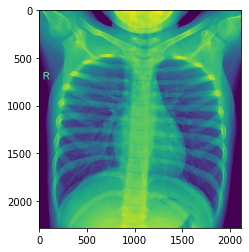

In [5]:
## get random file to check
img = data_path + '/train/NORMAL/'+ files_list_normal_train[np.random.randint(0,len(files_list_normal_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(776, 1224)


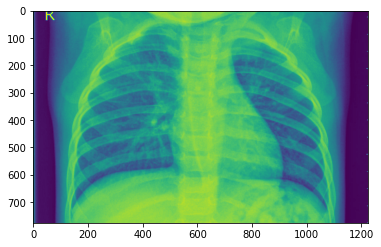

In [6]:
## get random file to check pneumona 
img = data_path + '/train/PNEUMONIA/'+ files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

In [8]:
train_transform = transforms.Compose([
    
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [9]:
## getting train and test data loader in place
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform= test_transform)

train_loader = DataLoader(train_data,
                          batch_size= 16, shuffle= True, pin_memory= True)
test_loader = DataLoader(test_data, 
                         batch_size= 1, shuffle= False, pin_memory= True)

class_names = train_data.classes

print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Training images available: 5232
Testing  images available: 624


## 4. Define Model

In [10]:

import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), 
                      padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) 
        self.pool11 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) 

        self.pool22 = nn.MaxPool2d(2, 2) 


        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(10),
        ) 
        self.pool33 = nn.MaxPool2d(2, 2) 
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(32),
           
        ) 


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
         
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )


        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
            
        ) 

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14)
            
        ) 

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16)
            
        ) 
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 

        self.convblockout = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),

        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)        
        x = self.convblockout(x)

        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)


In [11]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
       BatchNorm2d-3          [-1, 8, 222, 222]              16
         MaxPool2d-4          [-1, 8, 111, 111]               0
            Conv2d-5         [-1, 16, 109, 109]           1,152
              ReLU-6         [-1, 16, 109, 109]               0
       BatchNorm2d-7         [-1, 16, 109, 109]              32
         MaxPool2d-8           [-1, 16, 54, 54]               0
            Conv2d-9           [-1, 10, 54, 54]             160
             ReLU-10           [-1, 10, 54, 54]               0
      BatchNorm2d-11           [-1, 10, 54, 54]              20
        MaxPool2d-12           [-1, 10, 27, 27]               0
           Conv2d-13           [-1, 10, 25, 25]             900
             ReLU-14           [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## 5. Training

In [13]:


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(model, device, train_loader, optimizer, epoch,l1=0,lambda1 = 10e-4):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and even though thats used in RNN generally not used in CNN 
        # or specific requirements
        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        l1 = 0
        for p in model.parameters():
            l1=l1+p.abs().sum()
        loss = loss+lambda1*l1

        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_accuracies.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    test_accuracies.append(100. * correct / len(test_loader.dataset))


In [14]:


model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH number:", epoch)
    train(model, device, train_loader, optimizer, epoch,l1=0,lambda1 = 10e-4)
    scheduler.step()
    print('Current Learing Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

  0%|          | 0/327 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.8419995307922363 Batch_id=326 Accuracy=91.40: 100%|██████████| 327/327 [01:56<00:00,  2.82it/s]


current Learing Rate:  0.01


  0%|          | 0/327 [00:00<?, ?it/s]


Test set: Average loss: 0.5553, Accuracy: 518/624 (83.01%)

EPOCH: 1


Loss=0.5563547611236572 Batch_id=326 Accuracy=93.64: 100%|██████████| 327/327 [01:54<00:00,  2.85it/s]


current Learing Rate:  0.01


  0%|          | 0/327 [00:00<?, ?it/s]


Test set: Average loss: 0.4287, Accuracy: 512/624 (82.05%)

EPOCH: 2


Loss=0.7346203327178955 Batch_id=326 Accuracy=94.19: 100%|██████████| 327/327 [01:55<00:00,  2.83it/s]


current Learing Rate:  0.01


  0%|          | 0/327 [00:00<?, ?it/s]


Test set: Average loss: 0.3580, Accuracy: 537/624 (86.06%)

EPOCH: 3


Loss=0.35518980026245117 Batch_id=326 Accuracy=93.71: 100%|██████████| 327/327 [01:56<00:00,  2.80it/s]


current Learing Rate:  0.01


  0%|          | 0/327 [00:00<?, ?it/s]


Test set: Average loss: 1.1140, Accuracy: 413/624 (66.19%)

EPOCH: 4


Loss=0.5392647981643677 Batch_id=326 Accuracy=94.17: 100%|██████████| 327/327 [01:55<00:00,  2.82it/s]


current Learing Rate:  0.01


  0%|          | 0/327 [00:00<?, ?it/s]


Test set: Average loss: 0.4433, Accuracy: 520/624 (83.33%)

EPOCH: 5


Loss=0.5702544450759888 Batch_id=326 Accuracy=93.75: 100%|██████████| 327/327 [01:55<00:00,  2.82it/s]


current Learing Rate:  0.005


  0%|          | 0/327 [00:00<?, ?it/s]


Test set: Average loss: 0.4308, Accuracy: 504/624 (80.77%)

EPOCH: 6


Loss=0.26445573568344116 Batch_id=326 Accuracy=95.36: 100%|██████████| 327/327 [01:54<00:00,  2.85it/s]


current Learing Rate:  0.005


  0%|          | 0/327 [00:00<?, ?it/s]


Test set: Average loss: 0.6118, Accuracy: 494/624 (79.17%)

EPOCH: 7


Loss=0.4298825263977051 Batch_id=326 Accuracy=94.82: 100%|██████████| 327/327 [01:59<00:00,  2.74it/s]


current Learing Rate:  0.005


  0%|          | 0/327 [00:00<?, ?it/s]


Test set: Average loss: 0.5557, Accuracy: 505/624 (80.93%)

EPOCH: 8


Loss=0.3614543676376343 Batch_id=326 Accuracy=94.88: 100%|██████████| 327/327 [01:56<00:00,  2.80it/s]


current Learing Rate:  0.005


  0%|          | 0/327 [00:00<?, ?it/s]


Test set: Average loss: 0.6999, Accuracy: 461/624 (73.88%)

EPOCH: 9


Loss=0.3496456444263458 Batch_id=326 Accuracy=94.86: 100%|██████████| 327/327 [01:55<00:00,  2.83it/s]


current Learing Rate:  0.005


  0%|          | 0/327 [00:00<?, ?it/s]


Test set: Average loss: 0.4870, Accuracy: 509/624 (81.57%)

EPOCH: 10


Loss=0.4698035717010498 Batch_id=326 Accuracy=94.02: 100%|██████████| 327/327 [01:54<00:00,  2.86it/s]


current Learing Rate:  0.005


  0%|          | 0/327 [00:00<?, ?it/s]


Test set: Average loss: 0.4031, Accuracy: 529/624 (84.78%)

EPOCH: 11


Loss=0.25416579842567444 Batch_id=326 Accuracy=94.97: 100%|██████████| 327/327 [01:56<00:00,  2.81it/s]


current Learing Rate:  0.0025


  0%|          | 0/327 [00:00<?, ?it/s]


Test set: Average loss: 0.5346, Accuracy: 516/624 (82.69%)

EPOCH: 12


Loss=0.49813467264175415 Batch_id=326 Accuracy=95.20: 100%|██████████| 327/327 [01:57<00:00,  2.79it/s]


current Learing Rate:  0.0025


  0%|          | 0/327 [00:00<?, ?it/s]


Test set: Average loss: 0.5022, Accuracy: 513/624 (82.21%)

EPOCH: 13


Loss=0.23590919375419617 Batch_id=326 Accuracy=95.49: 100%|██████████| 327/327 [01:54<00:00,  2.85it/s]


current Learing Rate:  0.0025


  0%|          | 0/327 [00:00<?, ?it/s]


Test set: Average loss: 0.4407, Accuracy: 524/624 (83.97%)

EPOCH: 14


Loss=0.3934096097946167 Batch_id=326 Accuracy=95.41: 100%|██████████| 327/327 [01:53<00:00,  2.87it/s]


current Learing Rate:  0.0025

Test set: Average loss: 0.4265, Accuracy: 519/624 (83.17%)



Text(0.5, 1.0, 'Test Accuracy')

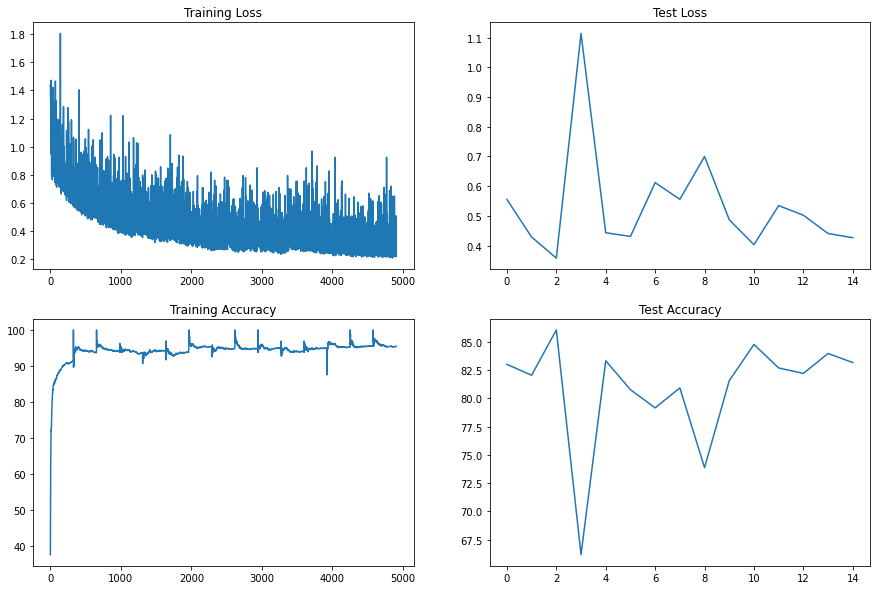

In [15]:

torch.cuda.synchronize()
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_accuracies]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_accuracies]

fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")